# MNE data structure exploration notebook

In this notebook, we explore the possibilities of MNE. MNE is an open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and more. It does not have a direct link to the paper but the expertise gained here is used in the paper.

This experimental notebook uses a database provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data, which gathered its functions from the experiments performed in `bci-master-thesis/experimental-notebooks/CLA-dataset-exploration-notebook.ipynb`.

Some other GitHub projects were found that also use this dataset, some of our code might be based on them. The code that was copied is annotated.  These GitHub projects are:

- [MotorImageryPreprocessing by zafeiriou-arg](https://github.com/zafeiriou-arg/MotorImageryPreprocessing)
- [Motor Imagery Classification by sauriii98](https://github.com/sauriii98/Motor-Imagery-Classification)

For this MNE portion we also used some of the tips and code samples from Richard Höchenberger's workshop on MNE Python:
- [Pybrain: M/EEG analysis with MNE Python](https://www.youtube.com/watch?v=t-twhNqgfSY)

## Table of Contents

- Checking requirements
    - Correct anaconda environment
    - Correct module access
    - Correct file access
- Loading in data
- Finding important markers
    - Loop for retreiving important markers
    - Analysing important markers
    - Plotting important markers

<hr><hr>

## Checking requirements

### Correct anaconda environment

The `bci-master-thesis` anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
import os
print("Active environment: "+ os.environ['CONDA_DEFAULT_ENV'])
print("Correct environment: " + str(os.environ['CONDA_DEFAULT_ENV'] == "bci-master-thesis"))

Active environment: bci-master-thesis
Correct environment: True


<hr>

### Correct module access

The following codeblock will load in all required modules.

In [2]:
# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# MNE package we're exploring
import mne

# Data manipulation modules
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt

<hr>

### Correct file access

As mentioned, this experimental notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`.

In [3]:
# Use util to determine if we have access
print("Access ok: " + str(CLA_dataset.check_file_availability()))

Access ok: True


<hr><hr>

## Loading in data

In this step, we load in the data. The data is provided as `.mat` files and thus originally meant for use with MATLAB. However, thanks to the written `CLA_dataset` util file we can easily get the MNE raw data from it.

Please specify the filename in the below codeblock. For more info on which variants are available, please look at the `bci-master-thesis/code/data/CLA/README.md` file.

Remember the meaning of the markers:
- 0: “blank” or nothing is displayed in eGUI
    - Can be seen as a break between stimuli, thus random EEG data that should probably be ignored
- 1: Left hand action
    - EEG data for MI of the left hand
- 2: Right hand action
    - EEG data for MI of the right hand
- 3: Passive/neutral
    - EEG data for MI of neither left nor right hand but 'focused'

In [4]:
# You can specify the data file to use here, per default it is CLASubjectA1601083StLRHand.mat
data_file_name = r'CLASubjectA1601083StLRHand.mat'

In [5]:
# Save the markers from the raw matlab data
data_markers = CLA_dataset.get_raw_matlab_data(data_file_name).marker

# Show labels overview
unique, counts = np.unique(data_markers, return_counts=True)
print("Markers present: " + str(dict(zip(unique, counts))))

# Cleaning up redundant variables from this codeblock
del unique
del counts

Markers present: {0: 476168, 1: 61490, 2: 69202, 3: 64740}


In [6]:
# Load in the file as MNE
mne_raw = CLA_dataset.get_raw_mne_data(data_file_name)

# Show the info
mne_raw.info

Creating RawArray with float64 data, n_channels=21, n_times=671600
    Range : 0 ... 671599 =      0.000 ...  3357.995 secs
Ready.


<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from CLASubjectA1601083StLRHand.mat
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2016-01-08 00:00:00 UTC
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

<hr><hr>

## Finding important markers

Since the data is one continuous stream of EEG data and we have the marker for each `hertz` / datapoint, it might be a good idea to note the indexes at which these markers change. This will give us an idea of where the data changes from stimulus to stimulus.

### Loop for retreiving important markers

The following loop will collect all important markers from the dataset.

In [7]:
print("First 5: " + str(data_markers[:5]))

print("Marker size equal to number of time points: " + str(len(data_markers) == mne_raw.n_times))

First 5: [0 0 0 0 0]
Marker size equal to number of time points: True


In [8]:
class ImportantMarkers:
    def __init__(self, new_value, old_value, start, end):
        self.new_value = new_value
        self.old_value = old_value
        self.start = start
        self.end = end

In [9]:
# Initial values
important_markers = []
new_value = -1
old_value = -1
start = -1
end = -1

for idx, marker in enumerate(data_markers):
    # Initial values
    if (start == -1):
        start = idx
        new_value = marker
        
    # Change of marker
    if (marker != new_value):
        # Save marker
        end = idx - 1
        important_markers.append(ImportantMarkers(new_value, old_value, start, end))
        
        # Start new marker
        old_value = new_value
        new_value = marker
        start = idx
        
# End of loop, create last record if needed
if (start > end):
    # Save marker
    end = idx
    important_markers.append(ImportantMarkers(new_value, old_value, start, end))
        
# Cleaning up redundant variables from this codeblock
del new_value
del old_value
del start
del end
del idx
del marker

<hr>

### Analysing important markers

Below we perform some basic analysis on the data gathered from the important markers and try to validate they make sense.

In [10]:
# View first 5
for important_marker in important_markers[:5]:
    print("Starting on " + str(important_marker.start)
          + " we changed from " 
          + str(important_marker.old_value)
          + " to "
          + str(important_marker.new_value)
          + " Which lasted untill "
          + str(important_marker.end))

Starting on 0 we changed from -1 to 0 Which lasted untill 37271
Starting on 37272 we changed from 0 to 3 Which lasted untill 37474
Starting on 37475 we changed from 3 to 0 Which lasted untill 37782
Starting on 37783 we changed from 0 to 3 Which lasted untill 37985
Starting on 37986 we changed from 3 to 0 Which lasted untill 38369


In [11]:
# View last 5
for important_marker in important_markers[-5:]:
    print("Starting on " + str(important_marker.start)
          + " we changed from " 
          + str(important_marker.old_value)
          + " to "
          + str(important_marker.new_value)
          + " Which lasted untill "
          + str(important_marker.end))

Starting on 667619 we changed from 3 to 0 Which lasted untill 667936
Starting on 667937 we changed from 0 to 2 Which lasted untill 668139
Starting on 668140 we changed from 2 to 0 Which lasted untill 668444
Starting on 668445 we changed from 0 to 3 Which lasted untill 668647
Starting on 668648 we changed from 3 to 0 Which lasted untill 671599


In [12]:
# Basic statistics
print("Total length was " + str(len(data_markers)))
print("This makes sense: " + str(len(data_markers) - 1 == important_markers[-1].end))

print()
print("Total amount of important markers: " + str(len(important_markers)))

Total length was 671600
This makes sense: True

Total amount of important markers: 1921


<hr>

### Plotting important markers

When plotting the evolution of these important markers it becomes clear that the stimulus is shown for 1 second (200 Hz) and the screen is blank for about 1.5 seconds (300 Hz).

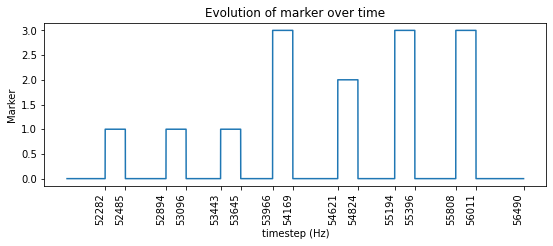

In [13]:
# Open plot inline
%matplotlib inline

# Data for plotting
subset_important_markers = important_markers[50:65]

# Setup canvas
plt.rcParams["figure.figsize"] = (9,3)

# Plotting code
x = sum([[x.start, x.end] for x in subset_important_markers], [])
y = sum([[y.new_value, y.new_value] for y in subset_important_markers], [])

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='timestep (Hz)', ylabel='Marker',
       title='Evolution of marker over time')

# Only show every 1 in 2 x points
x_labels = x[1::2]
plt.xticks(x_labels)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()
 
# Cleaning up redundant variables from this codeblock
del subset_important_markers
del fig
del ax
del x
del y

# Reset canvas
plt.rcParams.update(plt.rcParamsDefault)

<hr><hr>

## Plotting raw EEG data with MNE

Now that we have the `EMG RawArray object` and know the timestep of marker changes we can start making some interesting MNE plots. We will try this in what follows. We followed the [MNE documentation tutorials for this](https://mne.tools/dev/auto_tutorials/intro/10_overview.html).

In [14]:
type(mne_raw)

mne.io.array.array.RawArray

In [15]:
# Open plot in popup, comment this if it causes issues
%matplotlib qt 

# Show some plots
mne_raw.plot_psd(fmax=50)
mne_raw.plot(duration=5, n_channels=2)

print("plotting done")

Effective window size : 10.240 (s)
plotting done
Channels marked as bad: none
